In [ ]:
#!unzip /content/drive/MyDrive/Exp1_dataset.zip -d /content/drive/MyDrive/fer_experiments

In [ ]:
%cd /content/drive/MyDrive/fer_experiments

/content/drive/MyDrive/fer_experiments


In [ ]:

import cv2
import os
import glob
import keras
import numpy as np
from deepface import DeepFace
from keras.models import Model
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from attention_module import attach_attention_module
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D, GlobalAveragePooling2D,Input
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D,BatchNormalization

In [ ]:
def data_loader(dir,img_size):
  path = dir
  data_paths = os.path.join(path,'*g')
  imagePaths = glob.glob(data_paths)
  print("total files in imagePaths",len(imagePaths))

  labels=[]
  faces=[]
  for imgpath in imagePaths:
    images=cv2.imread(imgpath)
      
    #Face_detection---------------------------------------------------------
    backends = ['opencv', 'ssd', 'dlib', 'mtcnn', 'retinaface', 'mediapipe']
    face_detection = DeepFace.detectFace(img_path = images, target_size = img_size, detector_backend = backends[5], enforce_detection=False)
    
    #Dataset presentation----------------------------------------
    faces.append(face_detection)
    label= imgpath.split(os.path.sep)[-2].split("_")
    labels.append(label)

  return faces,labels
    

In [ ]:
def data_preprocessing(dir,img_size):
  images,labels=data_loader(dir,img_size)
  images=np.array(images)
  labels=np.array(labels)
  label_encoder = LabelEncoder()
  labels = label_encoder.fit_transform(labels)
  return images,labels
  

In [ ]:
dir="/content/drive/MyDrive/fer_experiments/Exp1_dataset/*"
img_size=(48,48)
images,labels=data_preprocessing(dir,img_size)

total files in imagePaths 38870


In [ ]:
# saving in numpy
images=np.save('/content/drive/MyDrive/fer_experiments/images',images)
labels=np.save('/content/drive/MyDrive/fer_experiments/labels',labels)

In [ ]:
#Loading data
images=np.load('/content/drive/MyDrive/fer_experiments/images.npy')
labels=np.load('/content/drive/MyDrive/fer_experiments/labels.npy')
print("Total Images",images.shape)
print("Total Labels",labels.shape)

Total Images (38870, 48, 48, 3)
Total Labels (38870,)


In [ ]:
#splitting data
x_train,x_test,y_train,y_test = train_test_split(images,labels,test_size=.1,random_state=True)
#one hot encoding
y_train = to_categorical(y_train)

print("Trainig images",x_train.shape)
print("Trainig labels",y_train.shape)
print("Test images",x_test.shape)
print("Test labels",y_test.shape)

Trainig images (34983, 48, 48, 3)
Trainig labels (34983, 7)
Test images (3887, 48, 48, 3)
Test labels (3887,)


In [ ]:
from keras.layers.attention.multi_head_attention import activation
def cusotm_cnn():
  input_shape = Input(shape=(48,48,3))
  x1 = Conv2D(32,kernel_size=(1,1),activation='relu',padding='same')(input_shape)
  x2 = Conv2D(32,kernel_size=(3,3),activation='relu',padding='same')(x1)

  x = attach_attention_module(x2, 'se_block')
  x = keras.layers.add([x, x2])
  x = Activation('relu')(x)


  x3 = Conv2D(64,kernel_size=(3,3),activation='relu',padding='same')(x2)
  x4 = Conv2D(64,kernel_size=(3,3),activation='relu',padding='same')(x3)
  x4 = MaxPooling2D(2,2)(x4)

  x = attach_attention_module(x4, 'se_block')
  x = keras.layers.add([x, x4])
  x = Activation('relu')(x)

  x5 = Conv2D(128,kernel_size=(3,3),activation='relu',padding='same')(x4)
  x6 = Conv2D(128,kernel_size=(3,3),activation='relu',padding='same')(x5)
  x7 = Conv2D(128,kernel_size=(3,3),activation='relu',padding='same')(x6)
  x7 = MaxPooling2D(2,2)(x7)

  x = attach_attention_module(x7, 'se_block')
  x = keras.layers.add([x, x7])
  x = Activation('relu')(x)

  x8 = Conv2D(256,kernel_size=(3,3),activation='relu',padding='same')(x7)
  x9 = Conv2D(256,kernel_size=(3,3),activation='relu',padding='same')(x8)
  x10 = Conv2D(256,kernel_size=(3,3),activation='relu',padding='same')(x9)
  x10 = MaxPooling2D(2,2)(x10)

  x = attach_attention_module(x10, 'se_block')
  x = keras.layers.add([x, x10])
  x = Activation('relu')(x)

  f = Flatten()(x)
  f1=Dense(512,activation='relu')(f)
  f2=Dense(256,activation='relu')(f1)
  out=Dense(7,activation='softmax')(f2)
  
  model = Model(inputs=input_shape, outputs=out)

  return model

In [ ]:
model = cusotm_cnn()
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d_131 (Conv2D)            (None, 48, 48, 32)   128         ['input_15[0][0]']               
                                                                                                  
 conv2d_132 (Conv2D)            (None, 48, 48, 32)   9248        ['conv2d_131[0][0]']             
                                                                                                  
 conv2d_133 (Conv2D)            (None, 48, 48, 64)   18496       ['conv2d_132[0][0]']             
                                                                                           

In [ ]:
opt=Adam(lr=(0.0003))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
#callbacks_baseline = create_callbacks_dropout()
history=model.fit(
        x=x_train,
        y=y_train,
        batch_size=32,
        epochs=5,
        validation_split=0.2
        #,callbacks = callbacks_baseline
         )

Epoch 1/5
875/875 [==============================] - 28s 31ms/step - loss: 1.8600 - accuracy: 0.2556 - val_loss: 1.7065 - val_accuracy: 0.3339
Epoch 2/5
875/875 [==============================] - 27s 31ms/step - loss: 1.5558 - accuracy: 0.4033 - val_loss: 1.4595 - val_accuracy: 0.4479
Epoch 3/5
875/875 [==============================] - 26s 30ms/step - loss: 1.3463 - accuracy: 0.4924 - val_loss: 1.3397 - val_accuracy: 0.4914
Epoch 4/5
875/875 [==============================] - 26s 30ms/step - loss: 1.1771 - accuracy: 0.5576 - val_loss: 1.2646 - val_accuracy: 0.5281
Epoch 5/5
875/875 [==============================] - 27s 30ms/step - loss: 0.9917 - accuracy: 0.6326 - val_loss: 1.2544 - val_accuracy: 0.5518


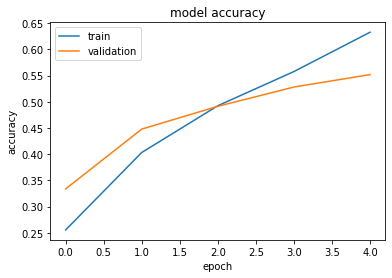

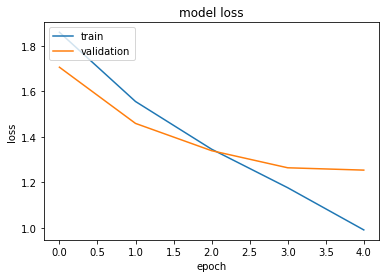

In [ ]:
#----------------------- Plot Training and Validation Accuracy curves -----------------------------
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()